# Fraud Detection in Credit Card Transactions

## Random Forest

## Versions

In [1]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import sklearn
import imblearn
import xgboost

print(f"Python version: {sys.version}")
print(f"Numpy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {seaborn.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Imbalanced-learn version: {imblearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:12:04) [Clang 18.1.8 ]
Numpy version: 2.1.0
Pandas version: 2.2.2
Matplotlib version: 3.9.2
Seaborn version: 0.13.2
Scikit-learn version: 1.5.1
Imbalanced-learn version: 0.13.0
XGBoost version: 2.1.4


### Importing Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from xgboost import XGBClassifier

In [3]:
df1 = pd.read_csv('creditcard_part1.csv')
df2 = pd.read_csv('creditcard_part2.csv')

# merge dataframes
ccdata = pd.concat([df1, df2], ignore_index=True)

## Modeling

In [4]:
# k-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

# function to plot confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, xticklabels=['Normal', 'Fraudulent'], yticklabels=['Normal', 'Fraudulent'], annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)

### Split

In [5]:
X = ccdata.drop('Class', axis=1)
y = ccdata['Class']

# 60% training, 20% validation, 20% testing
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=69, stratify=y_trainval)

In [6]:
print(f"Normal Transactions in training set (Class = 0):\t{y_train.value_counts()[0]}\t({y_train.value_counts()[0] / len(y_train)*100:.2f}%)")
print(f"Fraudulent Transactions in training set (Class = 1):\t{y_train.value_counts()[1]}\t({y_train.value_counts()[1] / len(y_train)*100:.2f}%)")

Normal Transactions in training set (Class = 0):	170588	(99.83%)
Fraudulent Transactions in training set (Class = 1):	295	(0.17%)


### Decision Tree

In [7]:
# model initialization
dtc = DecisionTreeClassifier(random_state=69, max_depth=15)

# model training
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=69)

Tree depth: 15

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.73      0.76        99

    accuracy                           1.00     56962
   macro avg       0.90      0.86      0.88     56962
weighted avg       1.00      1.00      1.00     56962



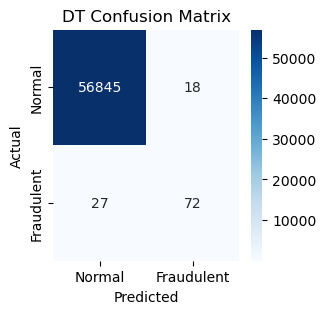

In [8]:
# prediction on validation set
y_val_pred_dtc = dtc.predict(X_val)
print(f"Tree depth: {dtc.get_depth()}\n")

# model evaluation on validation set
cm_dtc = confusion_matrix(y_val, y_val_pred_dtc)

print("Decision Tree Classification Report:")
print(classification_report(y_val, y_val_pred_dtc))

plot_confusion_matrix(cm_dtc, title="DT Confusion Matrix")

A higher precision and recall for fraudulent cases would be desirable.

### Random Forest

#### Imbalanced

In [9]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# hyperparameters to search
param_search = {'n_estimators': [50, 100], # number of trees
              'max_depth': [5, 10, 15], # maximum depth of the tree
#             'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
}

# searching best hyperparameters
rfc_search = GridSearchCV(
    rfc,
    param_search,
    cv=skf,
    scoring='f1',
    n_jobs=-2 # n_iter=10 is default
) 

# model training
rfc_search.fit(X_train, y_train)

print(f"Best Parameters:\t{rfc_search.best_params_}")

Best Parameters:	{'max_depth': 10, 'n_estimators': 100}


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.73      0.81        99

    accuracy                           1.00     56962
   macro avg       0.96      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962



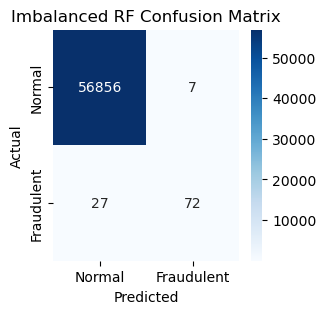

In [10]:
# prediction on validation set
y_val_pred_rfc = rfc_search.predict(X_val)

# model evaluation on validation set
cm_rfc = confusion_matrix(y_val, y_val_pred_rfc)

print("Random Forest Classification Report:")
print(classification_report(y_val, y_val_pred_rfc))

plot_confusion_matrix(cm_rfc, title="Imbalanced RF Confusion Matrix")

While the precision is higher than expected (91%), the random forest does not improve the recall (73%).

#### Undersampling

In [11]:
# undersampling method
rus = RandomUnderSampler(random_state=69)

# resampling
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print(f"Normal Transactions in training set (Class = 0):\t{y_train_under.value_counts()[0]}\t({y_train_under.value_counts()[0] / len(y_train_under)*100:.2f}%)")
print(f"Fraudulent Transactions in training set (Class = 1):\t{y_train_under.value_counts()[1]}\t({y_train_under.value_counts()[1] / len(y_train_under)*100:.2f}%)")

Normal Transactions in training set (Class = 0):	295	(50.00%)
Fraudulent Transactions in training set (Class = 1):	295	(50.00%)


In [12]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# hyperparameters to search
param_grid = {'n_estimators': [50, 100] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
             }

# searching best hyperparameters
rfc_search_under = GridSearchCV(
    rfc,
    param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-2 # n_iter=10 is default
)

# model training
rfc_search_under.fit(X_train_under, y_train_under)

print(f"Best Parameters:\t{rfc_search_under.best_params_}")

Best Parameters:	{'max_depth': 10, 'n_estimators': 100}


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.92      0.12        99

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



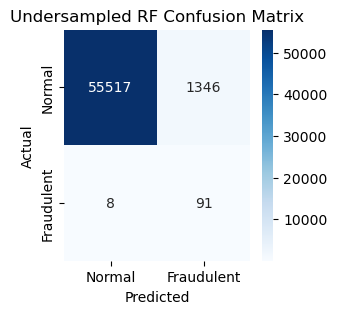

In [13]:
# prediction on validation set
y_val_pred_rfc_under = rfc_search_under.predict(X_val)

# model evaluation on validation set
cm_rfc_under = confusion_matrix(y_val, y_val_pred_rfc_under)

print("Random Forest Classification Report:")
print(classification_report(y_val, y_val_pred_rfc_under))

plot_confusion_matrix(cm_rfc_under, title="Undersampled RF Confusion Matrix")

Undersampling in the random forest achieved good recall (92%), but the precision dropped close to zero (6%). It appears that there is too much loss in information of the normal transactions.

#### Oversampling (ADASYN)

In [14]:
# oversampling initialisation
adasyn = ADASYN(sampling_strategy=0.5, random_state=69) # fraudulent cases resampled to 50% of the majority class
#smote = SMOTE(sampling_strategy=0.5, random_state=69) # fraudulent cases resampled to 50% of the majority class

# resampling training data
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)
#X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

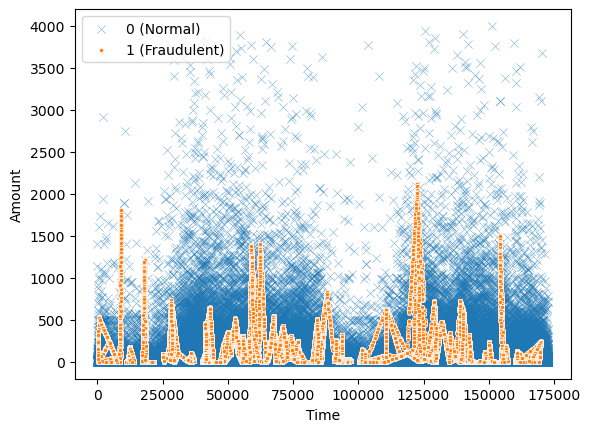

In [15]:
over_df = pd.DataFrame(X_train_over, columns=X_train_over.columns)
over_df['Class'] = y_train_over

sns.scatterplot(data=over_df[(over_df['Amount'] < 4000) & (over_df['Class'] == 0)], y='Amount', x='Time', alpha=0.5, marker='x', label='0 (Normal)')
sns.scatterplot(data=over_df[(over_df['Amount'] < 4000) & (over_df['Class'] == 1)], y='Amount', x='Time', alpha=1, marker='.', label='1 (Fraudulent)', color='tab:orange')
plt.legend();

In [16]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# hyperparameters to search
param_grid = {'n_estimators': [50, 100] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
}

# searching best hyperparameters
rfc_search_over = GridSearchCV(
    rfc,
    param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-2 # n_iter=10 is default
)

# model training
rfc_search_over.fit(X_train_over, y_train_over)

print(f"Best Parameters:\t{rfc_search_over.best_params_}")

Best Parameters:	{'max_depth': 15, 'n_estimators': 50}


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.84      0.82      0.83        99

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



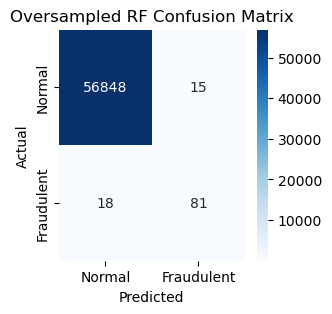

In [17]:
# prediction on validation set
y_val_pred_rfc_over = rfc_search_over.predict(X_val)

# model evaluation on validation set
cm_rfc_over = confusion_matrix(y_val, y_val_pred_rfc_over)

print("Random Forest Classification Report:")
print(classification_report(y_val, y_val_pred_rfc_over))

plot_confusion_matrix(cm_rfc_over, title="Oversampled RF Confusion Matrix")

Precision and recall are more balanced. However, there appears to be room for improvement as we have seen significantly higher precision or recall separately before.

#### Boosting

In [18]:
# AdaBoost Model
adaboost = AdaBoostClassifier(n_estimators=50, random_state=69)
adaboost.fit(X_train, y_train)

# Gradient Boosting Model
gradientboosting = GradientBoostingClassifier(n_estimators=50, random_state=69)
gradientboosting.fit(X_train, y_train)

# XGBoost
xgbc = XGBClassifier(n_estimators=50, random_state=69, nthread=4)
xgbc.fit(X_train, y_train)

/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [19]:
# AdaBoost evaluation
y_pred_ada = adaboost.predict(X_val)
cm_ada = confusion_matrix(y_val, y_pred_ada)
print('AdaBoost Classification Report:')
print(classification_report(y_val, y_pred_ada))
print(cm_ada)
#plot_confusion_matrix(cm_ada, title='AdaBoost Confusion Matrix')

# Gradient Boosting evaluation
y_pred_gb = gradientboosting.predict(X_val)
cm_gb = confusion_matrix(y_val, y_pred_gb)
print('Gradient Boosting Classification Report:')
print(classification_report(y_val, y_pred_gb))
print(cm_gb)
#plot_confusion_matrix(cm_gb, title='Gradient Boosting Confusion Matrix')

# XGBoost evaluation
y_pred_xgb = xgbc.predict(X_val)
cm_xgbc = confusion_matrix(y_val, y_pred_xgb)
print('XGBoost Classification Report:')
print(classification_report(y_val, y_pred_xgb))
print(cm_xgbc)
#plot_confusion_matrix(cm_xgbc, title='XGBoost Confusion Matrix')

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.79      0.71      0.74        99

    accuracy                           1.00     56962
   macro avg       0.89      0.85      0.87     56962
weighted avg       1.00      1.00      1.00     56962

[[56844    19]
 [   29    70]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.35      0.49        99

    accuracy                           1.00     56962
   macro avg       0.91      0.68      0.75     56962
weighted avg       1.00      1.00      1.00     56962

[[56855     8]
 [   64    35]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.81      0.86        99

    accuracy    

XGBoost outperforms AdaBoost and Gradient Boosting in both precision and recall clearly. We will attempt more improvement through hyperparameter tuning.

##### Hyperparameter Tuned XGBoost Model

In [20]:
# scale_pos_weight (helps XGBoost handle imbalance)
neg, pos = y_train_over.value_counts()
scale_pos_weight = neg / pos

# model initialization
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
#    scale_pos_weight=scale_pos_weight, # uncomment if not using oversampled data
    use_label_encoder=False,
    nthread=4,
    random_state=69
)

# hyperparameter grid
param_grid = {
    'n_estimators': [100, 500], # number of trees
    'max_depth': [3, 5], # max depth of tree
    'min_child_weight': [1, 3], # about min samples per leaf
    'colsample_bytree': [0.8, 1], # max features per tree
    'learning_rate': [0.2, 0.3]
}

# searching best hyperparameters
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',  # or use 'roc_auc' or 'average_precision'
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# model training
grid_search.fit(X_train_over, y_train_over)

# best model
best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:50:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444238318/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:50:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444238318/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:50:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444238318/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarn

Best Params: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500}


ROC AUC: 0.9763967515756904
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.84      0.87        99

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



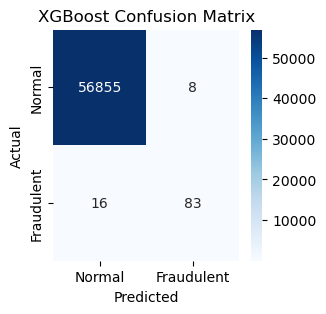

In [21]:
# prediction on validation set (best model)
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# model evaluation on validation set
print("ROC AUC:", roc_auc_score(y_val, y_val_proba))

cm_xgb = confusion_matrix(y_val, y_val_pred)
print("XGBoost Classification Report:")
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(cm_xgb, title="XGBoost Confusion Matrix")

XGBoost improved false labels, especially false positives. Increasing the k-fold from 3 to 5 worsened the ROC AUC outcome by 0.67% (97.64% vs 98.31%) but it may make the model more generalizable.

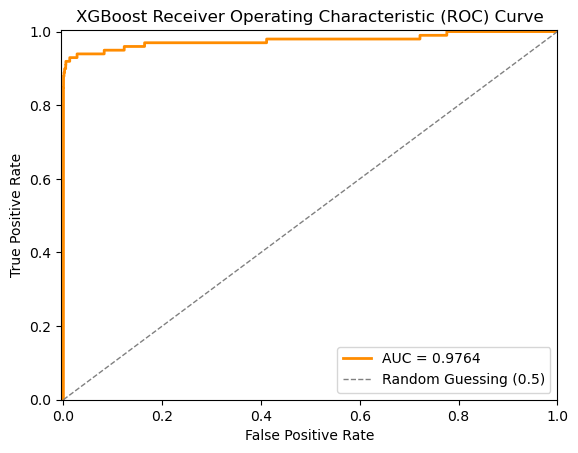

In [22]:
# ROC curve
fpr, tpr, threshold = roc_curve(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='darkorange', lw=2)

plt.plot([0, 1], [0, 1],'--', color='gray', lw=1, label='Random Guessing (0.5)')

plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.xlim([-0.004, 1])
plt.ylim([0, 1.004]);

###### Feature Importance

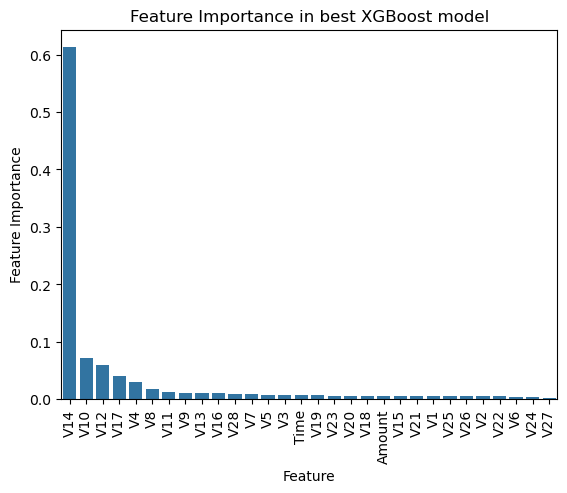

In [23]:
f_importance_df = pd.DataFrame({'Feature': X_val.columns, 'Feature Importance': best_model.feature_importances_})
f_importance_df = f_importance_df.sort_values(by='Feature Importance',ascending=False)

plt.title('Feature Importance in best XGBoost model')
sns.barplot(x='Feature', y='Feature Importance', data=f_importance_df);
plt.xticks(rotation=90);

The V14 principal component is by far the most important feature in the model. It accounts for over 60% of the prediction.

###### Test Evaluation

ROC AUC: 0.9863948569016803
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



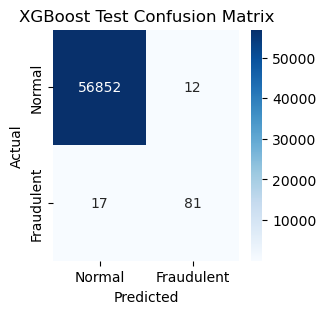

In [24]:
# prediction on test set (best model)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# model evaluation on test set
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))

cm_xgb_test = confusion_matrix(y_test, y_test_pred)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(cm_xgb_test, title="XGBoost Test Confusion Matrix")

The AUC increased on the test set while precision and recall decreased by 4% and 1%. Overall, it appears that the model is generalizing well.